## Precision and Recall

### Import packages

In [1]:
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

### Load similarity matrix

In [2]:
similarity_one = torch.load("similarity_one.pth")
similarity_many = torch.load("similarity_many.pth")

In [5]:
print(similarity_one.shape)
print(similarity_many.shape)

torch.Size([34, 136])
torch.Size([34, 136])


### Save two matrices of my image retrieval [one2one, many2many]

In [8]:
_, topk4_one2one   = torch.topk(similarity_one, 4, dim = 1)
_, topk4_many2many = torch.topk(similarity_many, 4, dim = 1)
print(topk4_one2one.shape)
print(topk4_many2many.shape)
torch.save([topk4_many2many, topk4_one2one], "retrieval.pth")

topk4_one2one

torch.Size([34, 4])
torch.Size([34, 4])


tensor([[  0,   1,   2,   3],
        [  4,   6,  55,  54],
        [  8,  87,  50,  71],
        [ 13,  15,  12,  14],
        [ 18,  16,  19,  17],
        [ 22,  20,  21,  23],
        [ 26,  27,  52,  54],
        [ 28, 114,  30, 112],
        [ 34,  52,  53,   5],
        [ 39,  37,  38,  36],
        [ 42,  40,  41,  43],
        [ 44,  47, 133, 107],
        [ 51,  50,  48,  49],
        [ 55,  54,  33,  35],
        [ 56,  58,  57,  59],
        [ 61,  60,  62,  63],
        [ 66,  64,  67,  65],
        [ 70,  69, 111,  59],
        [ 72,  73,  74,  75],
        [ 79, 126,  72,  76],
        [ 83, 132,  89,  82],
        [ 84,  85,  86,  87],
        [ 90,  88,  89, 111],
        [ 92, 135,  85,  87],
        [ 96,  97,  99,  98],
        [100, 101, 102, 103],
        [104, 106,  19,  50],
        [110, 108, 109, 134],
        [112, 114, 113,  26],
        [116, 117, 119, 118],
        [122, 120, 123,  93],
        [124, 117,  95,  14],
        [128, 129,  62, 131],
        [1

### Make two sets of K most similar images

In [17]:
topk_one_index = torch.zeros(4, 34, 4)
topk_many_index = torch.zeros(4, 34, 4)

for k in range(4):
    _, topk_one   = torch.topk(similarity_one, k+1, dim = 1)
    _, topk_many = torch.topk(similarity_many, k+1, dim = 1)
    
    topk_one_index[k, :, :k+1] = topk_one + 1
    topk_many_index[k, :, :k+1] = topk_many + 1

In [18]:
# read ground truth
ground_truth = torch.empty(34, 4)
with open("image_retrieval/ground_truth.txt", 'r') as f:
    adder = 0
    for line in f:
        if not line.startswith("q"):
            continue
        one_line = line.strip().split("  ")
        query_index = int(one_line[0][1:])
        image_index = int(one_line[1])
        ground_truth[query_index - 1][adder % 4] = image_index
        adder += 1

In [19]:
P_one2one = torch.zeros(4,1)
R_one2one = torch.zeros(4,1)
for k in range(4):
    P_1, R_1 = 0, 0
    for idx in range(34):
        for topk_idx in topk_one_index[k][idx][:k+1]:
            if int(topk_idx) in ground_truth[idx]:
                P_1 += 1/(k+1)/34 # sum_P /Q
                R_1 += 1/4/34
    P_one2one[k] = P_1
    R_one2one[k] = R_1
    
P_many2many = torch.zeros(4,1)
R_many2many = torch.zeros(4,1)
for k in range(4):
    P_1, R_1 = 0, 0
    for idx in range(34):
        for topk_idx in topk_many_index[k][idx][:k+1]:
            if int(topk_idx) in ground_truth[idx]:
                P_1 += 1/(k+1)/34 # sum_P /Q
                R_1 += 1/4/34
    P_many2many[k] = P_1
    R_many2many[k] = R_1

### Compute average precision and recall

In [20]:
topk_many_index.shape

torch.Size([4, 34, 4])

In [21]:
def precision_recall(topk_index, ground_truth):
    precision = torch.zeros(4,1)
    recall = torch.zeros(4,1)
    for k in range(4):
        p, r = 0, 0
        for i in range(34):
            for j in topk_index[k][i][:k+1]:
                if int(j) in ground_truth[i]:
                    p += 1/(k+1)/34
                    r += 1/4/34
        precision[k] = p
        recall[k] = r
    return precision.numpy(), recall.numpy()

In [22]:
precision_one, recall_one = precision_recall(topk_one_index, ground_truth)
precision_many, recall_many = precision_recall(topk_many_index, ground_truth)

In [23]:
print(precision_one)
print(recall_one)
print(precision_many)
print(recall_many)

[[1.        ]
 [0.89705884]
 [0.8039216 ]
 [0.74264705]]
[[0.25      ]
 [0.44852942]
 [0.60294116]
 [0.74264705]]
[[0.85294116]
 [0.75      ]
 [0.6372549 ]
 [0.5955882 ]]
[[0.21323529]
 [0.375     ]
 [0.4779412 ]
 [0.5955882 ]]


### Image visualization: Precision vs Recall

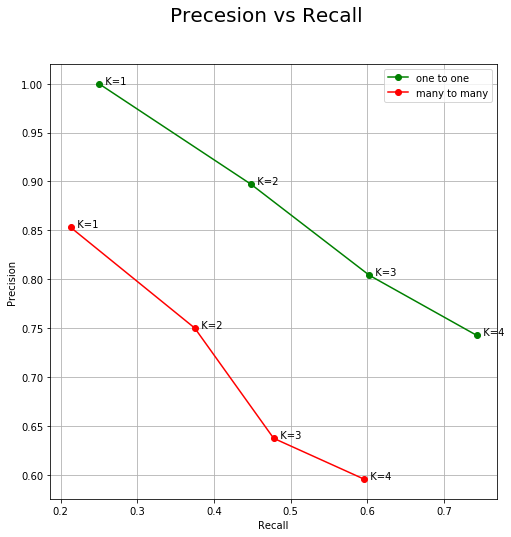

In [24]:
k = [i for i in range(1, 5)]
fig = plt.figure(figsize=(8, 8))
plt.suptitle('Precesion vs Recall', fontsize=20)
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Precision')
ax1.set_xlabel('Recall')
ax1.grid(True)
data1 = ax1.plot(recall_one, precision_one, '-go',label = 'one to one')
for i in range(4):
    ax1.annotate('  K={}'.format(i + 1), xy = (recall_one[i], precision_one[i]), textcoords = 'data')
    ax1.annotate('  K={}'.format(i + 1), xy = (recall_many[i], precision_many[i]), textcoords = 'data')
data2 = ax1.plot(recall_many, precision_many, '-ro',label = 'many to many')
data3 = data1 + data2
data4 = [h.get_label() for h in data3]
ax1.legend(data3, data4, loc=0)
plt.show()

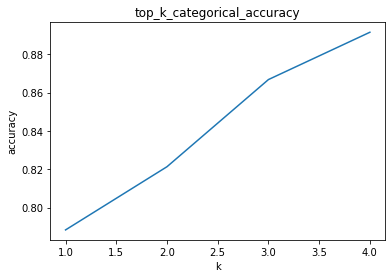

In [8]:
import matplotlib.pyplot as plt

acc = [0.7883, 0.8213, 0.8668, 0.8915]
k = range(1,5)
plt.plot(k, acc)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('top_k_categorical_accuracy')
plt.show()